In [2]:
from pathlib import Path
from matplotlib import pyplot as plt
import pysam 
import numpy as np
from Bio import SeqIO
import time 
import matplotlib.patches as patches
import matplotlib.cm as cm
import itertools
from tabulate import tabulate
import csv
import random

np.set_printoptions(threshold=np.inf)
min_quality_score = 8



assembly_ = open("/private/groups/migalab/dan/reference/hg002v1.0.1.fasta", "r")

start_time = time.time()

#Load the reference genome and make it into a dictionary 
fasta_sequences = SeqIO.parse(assembly_, "fasta")
assembly={}
for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    assembly[name] = sequence

#Make a dictionary for all the chromosomes and their corresponding sequence length 
assembly_sequence_length = {}    
for chromosome in assembly:
    assembly_sequence_length[chromosome] = len(assembly[chromosome])
    
end_time = time.time()
elapsed_time = end_time - start_time
print (elapsed_time, "seconds")
assembly_.close()



59.31376028060913 seconds


In [3]:
CDR_regions = '/private/groups/migalab/dan/data_analysis/young_old_analysis/HG002_DiMeLo_CENPA_youngpassage.hmmCDR_only_CDR_Dan_certified.bed'
output_dir = Path('/private/groups/migalab/dan/data_analysis/HG002_figure2/b_revised_multi_region')
CENPA_AS_bam_file = '/private/groups/migalab/dan/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1/20240611_1126_1H_PAW33460_814408d8/pod5/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1_5mA_6mC_winnowmap_MD.bam'
CENPC_AS_bam_file = '/private/groups/migalab/dan/01_09_24_R1041_DiMeLoAdaptive_CENPC/01_09_24_R1041_DiMeLoAdaptive_CENPC/01_09_24_R1041_DiMeLoAdaptive_CENPC/20240109_1200_6B_PAS52674_0adbae11/pod5_pass/explicit/01_09_24_R1041_DiMeLoAdaptive_CENPC_5mC_6mA_winnowmap_sorted_MD.bam'
H3K9me3_AS_bam_file = '/private/groups/migalab/dan/08_05_24_R1041_ULadapt_Dimelo_H3K9ME3/08_05_24_R1041_ULadapt_Dimelo_H3K4ME3/08_05_24_R1041_ULadapt_Dimelo_H3K4ME3_1/20240805_1148_1F_PAU87705_0451cc00/pod5/08_05_24_R1041_ULadapt_Dimelo_H3K4ME3_mA_mC_winnowmap_sorted_MD.bam'
ref_genome_file = Path('/private/groups/migalab/dan/reference/hg002v1.0.1.fasta')


In [4]:
''' here in the code, I am formulating the CDR regions and listing the CDRs in each and every chromosome'''
input_file = '/private/groups/migalab/dan/data_analysis/young_old_analysis/HG002_DiMeLo_CENPA_youngpassage.hmmCDR_only_CDR_Dan_certified.bed'
CDR_dict = {}
with open(input_file, 'r') as infile:  
    for i in infile:
        chr_num = i.split('\t')[0]
        CDR_start = i.split('\t')[1]cd 
        CDR_end = i.split('\t')[2].split('\n')[0]
        if chr_num not in CDR_dict:
            CDR_dict[chr_num] = [[CDR_start ,CDR_end]]
        elif chr_num in CDR_dict:  
            CDR_dict[chr_num].append ([CDR_start ,CDR_end])





In [5]:
# Open the BAM file
CENPA_bamfile = pysam.AlignmentFile(CENPA_AS_bam_file, "rb")
CENPC_bamfile = pysam.AlignmentFile(CENPC_AS_bam_file, "rb")
H3K9_bamfile = pysam.AlignmentFile(H3K9me3_AS_bam_file, "rb")

In [34]:
import pysam

def read_spans_regions(read, regions, thres):
    """
    For each region in 'regions', this function checks whether the read fully spans the 
    central portion (as defined by 'thres') of that region. It returns the count of regions 
    that are fully spanned as well as a list of the region start positions.
    """
    start_list = []
    span_count = 0
    for region in regions:
        # Convert region coordinates to integers (region can be tuple or list)
        region = (int(region[0]), int(region[1]))
        start, end = region
        mid_point = (end + start) / 2

        # Only consider the region if the read fully covers it.
        if read.reference_start > start or read.reference_end < end:
            continue

        # Calculate the central coverage range based on the threshold.
        coverage_range = (end - start) * (thres / 100) / 2
        threshold_start = mid_point - coverage_range
        threshold_end = mid_point + coverage_range

        # Check if the read spans the threshold region.
        if read.reference_start <= threshold_start and read.reference_end >= threshold_end:
            span_count += 1
            start_list.append(start)
    return span_count, start_list


def tag_spanning_reads_on_chromosome_two_outputs(input_bam, output_bam_gt_path, output_bam_lt_path,
                                                 CDR_dict, chromosome, thres=100,
                                                 target_region=None, target_regions=None,
                                                 total_target_regions=None):
    """
    Processes reads on a specified chromosome from an input BAM file (or pysam.AlignmentFile object)
    and writes them to one of two output BAM files based on their span_count.
    
    For each read with query_length > 50000:
      - The span_count is computed over all regions in CDR_dict for the specified chromosome.
      - If span_count > 1, the read is tagged with "YC" (with the value set to span_count) 
        and written to the 'gt' output file.
      - Otherwise, the read is written to the 'lt' output file without any tag.
    
    Additionally, you may optionally provide:
      - target_region (a single region tuple) or 
      - target_regions (a tuple or list of exactly two region tuples)
      
    In these cases the function counts the number of reads that fully span the provided region(s).
    
    Finally, you may optionally provide:
      - total_target_regions (a region tuple or a list/tuple of region tuples)
      
    In this case the function counts the total number of reads that overlap (i.e. have any base in common with)
    any of the provided total_target_regions. Overlap is defined by the condition:
        read.reference_end > region_start and read.reference_start < region_end
    
    Returns:
        A dictionary with keys:
          - 'fully_spanning': the count from target_region(s) if provided (or None if not),
          - 'overlap': the count of reads overlapping total_target_regions if provided (or None if not).
        If neither type of count is requested, returns None.
    """
    # Get the list of regions for the specified chromosome.
    regions = CDR_dict.get(chromosome, [])
    # Convert all regions from CDR_dict to tuples of integers for consistency.
    regions_converted = [(int(r[0]), int(r[1])) for r in regions]
    
    # Process the optional fully spanning target region(s)
    fully_span_count = None
    if target_regions is not None:
        # Ensure we got exactly two regions.
        if not (isinstance(target_regions, (list, tuple)) and len(target_regions) == 2):
            print("Warning: target_regions must be a tuple or list of two regions. Ignoring target_regions.")
            target_regions = None
        else:
            # Convert target regions to tuples of integers.
            target_regions = [ (int(tr[0]), int(tr[1])) if isinstance(tr[0], str) else tuple(tr)
                               for tr in target_regions ]
            # Check if each target region exists in regions_converted.
            for tr in target_regions:
                if tr not in regions_converted:
                    print(f"Warning: target region {tr} not found in CDR_dict for this chromosome. Ignoring target_regions.")
                    target_regions = None
                    break
            if target_regions is not None:
                fully_span_count = 0
    elif target_region is not None:
        target_region = (int(target_region[0]), int(target_region[1])) if isinstance(target_region[0], str) else tuple(target_region)
        if target_region not in regions_converted:
            print(f"Warning: target region {target_region} not found in CDR_dict for this chromosome. Ignoring target_region.")
            target_region = None
        else:
            fully_span_count = 0

    # Process the optional overlap counting target regions.
    total_overlap_count = None
    if total_target_regions is not None:
        # Allow a single region or a list/tuple of regions.
        if not isinstance(total_target_regions, (list, tuple)):
            total_target_regions = [total_target_regions]
        else:
            total_target_regions = list(total_target_regions)
        # Convert to tuples of integers.
        total_target_regions = [ (int(r[0]), int(r[1])) if isinstance(r[0], str) else tuple(r)
                                  for r in total_target_regions ]
        total_overlap_count = 0

    # Open the input BAM file if necessary.
    if isinstance(input_bam, str):
        in_bam = pysam.AlignmentFile(input_bam, "rb")
        close_in_bam = True
    else:
        in_bam = input_bam
        close_in_bam = False

    # Open both output BAM files using the input as a template.
    with pysam.AlignmentFile(output_bam_gt_path, "wb", template=in_bam) as out_bam_gt, \
         pysam.AlignmentFile(output_bam_lt_path, "wb", template=in_bam) as out_bam_lt:
        
        # Process only reads on the specified chromosome.
        for read in in_bam.fetch(chromosome):
            # For reads shorter than 50000, write them to the 'lt' file.
            if read.query_length <= 50000:
                out_bam_lt.write(read)
                continue
            
            # If fully spanning target region(s) are provided, count reads that fully span them.
            if target_regions is not None:
                span_count_1, _ = read_spans_regions(read, [target_regions[0]], thres)
                span_count_2, _ = read_spans_regions(read, [target_regions[1]], thres)
                if span_count_1 > 0 and span_count_2 > 0:
                    fully_span_count += 1
            elif target_region is not None:
                span_count_target, _ = read_spans_regions(read, [target_region], thres)
                if span_count_target > 0:
                    fully_span_count += 1

            # If total overlap regions are provided, count reads that overlap any of them.
            if total_overlap_count is not None:
                # Check if the read overlaps at least one of the regions.
                for reg in total_target_regions:
                    # Overlap condition: at least one base in common.
                    if read.reference_end > reg[0] and read.reference_start < reg[1]:
                        total_overlap_count += 1
                        break  # Count the read only once.
            
            # Compute span_count over all regions in CDR_dict for the chromosome.
            span_count, _ = read_spans_regions(read, regions_converted, thres)
            if span_count > 1:
                read.set_tag("YC", span_count)
                out_bam_gt.write(read)
            else:
                out_bam_lt.write(read)
    
    if close_in_bam:
        in_bam.close()

    # Print and return the counts if requested.
    results = {}
    if fully_span_count is not None:
        if target_regions is not None:
            print(f"Number of reads fully spanning both target regions {target_regions[0]} and {target_regions[1]}: {fully_span_count}")
        elif target_region is not None:
            print(f"Number of reads fully spanning target region {target_region}: {fully_span_count}")
        results['fully_spanning'] = fully_span_count
    if total_overlap_count is not None:
        if len(total_target_regions) == 1:
            print(f"Number of reads overlapping target region {total_target_regions[0]}: {total_overlap_count}")
        else:
            print(f"Number of reads overlapping any of the target regions {total_target_regions}: {total_overlap_count}")
        results['overlap'] = total_overlap_count

    return results if results else None

# Example usage:
# Without any target counting:
# tag_spanning_reads_on_chromosome_two_outputs("input.bam", "output_gt.bam", "output_lt.bam", CDR_dict, "chrX_MATERNAL")
#
# With fully spanning count for two regions:
# results = tag_spanning_reads_on_chromosome_two_outputs("input.bam",
#                                                      "output_gt.bam",
#                                                      "output_lt.bam",
#                                                      CDR_dict,
#                                                      "chrX_MATERNAL",
#                                                      target_regions=[(59465035, 59476699), (59422135, 59446739)])
#
# With overlap count (total reads overlapping the regions, not requiring full span):
# results = tag_spanning_reads_on_chromosome_two_outputs("input.bam",
#                                                      "output_gt.bam",
#                                                      "output_lt.bam",
#                                                      CDR_dict,
#                                                      "chrX_MATERNAL",
#                                                      total_target_regions=[(59465035, 59476699), (59422135, 59446739)])
#
# You can also provide both kinds of target regions simultaneously; in that case the returned
# dictionary will include both 'fully_sp


In [36]:
count = tag_spanning_reads_on_chromosome_two_outputs(H3K9_bamfile,
                                                      "/private/groups/migalab/dan/data_analysis/HG002_figure3/spanning_reads_chromosome/H3K9me3_read_tagged_span.bam",
                                                      "/private/groups/migalab/dan/data_analysis/HG002_figure3/spanning_reads_chromosome/H3K9me3_read_tagged_single.bam",
                                                      CDR_dict,
                                                      "chrX_MATERNAL",
                                                      total_target_regions=[(59465035, 59476699), (59483830, 59504887)])
print (count )

Number of reads overlapping any of the target regions [(59465035, 59476699), (59483830, 59504887)]: 45
{'overlap': 45}


In [33]:
print (count)

{'fully_spanning': 19}


In [15]:
print (CDR_dict)

{'chr10_MATERNAL': [['42097255', '42102611'], ['42139864', '42150884'], ['42214295', '42277197']], 'chr10_PATERNAL': [['41441384', '41447407'], ['41454240', '41458568'], ['41462117', '41470849'], ['41479759', '41497507'], ['41503453', '41524132'], ['41562489', '41571836'], ['41578169', '41583627'], ['41594115', '41605438']], 'chr11_MATERNAL': [['54048169', '54104765'], ['54111022', '54141397'], ['54172305', '54178962'], ['54236898', '54249481']], 'chr11_PATERNAL': [['52514054', '52522111'], ['52548461', '52590411'], ['52644773', '52685555'], ['52689176', '52700370']], 'chr12_MATERNAL': [['35773137', '35778391'], ['35781232', '35789106'], ['35812185', '35837664'], ['35845155', '35855661'], ['35876735', '35884128'], ['35957915', '35972991'], ['35978300', '36001274']], 'chr12_PATERNAL': [['34765267', '34778730'], ['34800276', '34824172'], ['34827012', '34858173'], ['34879958', '34888597'], ['34911810', '34929708']], 'chr13_MATERNAL': [['16052370', '16058022'], ['16061329', '16075186'], ['

In [31]:
H3K9_spanning_reads = get_spanning_reads(H3K9_bamfile, CDR_dict)
#CENPC_spanning_reads = get_spanning_reads(CENPC_bamfile, CDR_dict)

In [32]:
'''
The idea of this function is to isolate the the desired regions (here in the function, it is called the subset) in the mod 
numpy array without dashes(insertions)'''

def mod_subset_producing_step (mod_no_dash,alignment_dash,target_start_no_dash,target_end_no_dash):
    #mod_no_dash = is the numpy array of the mod without any insertions and deletions
    # alignment_dash = is the alignment sequence with the dashes in it 
    # target_start = it's the subset starting position WITHOUT the dashes!!! 


    # Create a mask to identify non-dash positions
    mask = [char != '-' for char in alignment_dash]

    # Generate cumulative counts only for True values in the mask
    cumulative_counts = list(itertools.accumulate(mask))


    
    # Create the final indexes list
    indexes = [count - 1 if is_non_dash else '-' for count, is_non_dash in zip(cumulative_counts, mask)]



    target_start_dash = indexes.index (target_start_no_dash)

        
    try:
        target_end_dash = indexes.index (target_end_no_dash)
    except ValueError: 
        target_end_dash = indexes[-1]




    #obtain dashed alignment 
    alignment_dash_sequence_pre_subset = alignment_dash[0:target_start_dash]
    alignment_dash_sequence_subset = alignment_dash[target_start_dash:target_end_dash]

    #create no dash alignment 
    alignment_no_dash_sequence_pre_subset = alignment_dash_sequence_pre_subset.replace("-","")
    alignment_no_dash_sequence_subset = alignment_dash_sequence_subset.replace("-","")

    subset_no_dash_start = len(alignment_no_dash_sequence_pre_subset)
    subset_no_dash_end = subset_no_dash_start + len(alignment_no_dash_sequence_subset)

    #make mod_no_dash alignment
    mod_subset = mod_no_dash[subset_no_dash_start:subset_no_dash_end]

    return mod_subset





In [33]:
''' 
The input of the function is a dictionary in the format of 'chromosome':[[start,end],[start,end]] 
'''
def region_read_mA_density_calculator (chromosome_coordinates,threshold,mod_tag,filtering_val,mC_threshold_dict, bamfile,spanning_reads,percentage): 
    read_region_check = {}
    read_CDR_region_distribution = {}


    #get each chromosome
    for chr_name in chromosome_coordinates:

        for region in chromosome_coordinates[chr_name]:
            region_base = 0 

            region_start_index = int(region[0])
            region_end_index = int(region[1])

            
            for read in bamfile.fetch(chr_name,region_start_index,region_end_index):
                chromosome = bamfile.get_reference_name(read.reference_id)
                read_name = read.query_name 
                read_start_position = read.reference_start
                read_end_position = read.reference_end
                
                
                    
                if (read_name in spanning_reads)  and (region_start_index in spanning_reads[read_name]):
                    
                    
                    #make an if statement to check a specific read front, middle, end regions 
                    #setting read start, end, density, length variables 
                        

                    #Get the starting and ending positions of the reads 
                    
                    read_density = 0 

                
                    #Get sequence information which shows deletions and insertions 
                    sequence = read.get_aligned_pairs(matches_only=False, with_seq = True)


                    #make |a numpy of the sequence length which eliminates the deletion
                    read_sequence_insertion_included = ''
                    genomic_alignment_sequence_deletion_mistach_included = ''
                    
                    for item in sequence:
                        if item[0] is None:
                            read_sequence_insertion_included+='-'
                        elif item[1] is None:
                            genomic_alignment_sequence_deletion_mistach_included += '-'
                        else: 
                            read_sequence_insertion_included+=item[2]
                            genomic_alignment_sequence_deletion_mistach_included +=item[2]

                    
                    #take sequence length excluding insertions 
                    read_sequence_insertion_included = read_sequence_insertion_included.upper()
                    genomic_alignment_sequence_deletion_mistach_included = genomic_alignment_sequence_deletion_mistach_included.upper()
                    
                    genomic_alignment_sequence_deletion_mistach_included_mask = np.array(
                    [char != '-' for char in genomic_alignment_sequence_deletion_mistach_included])

                    insertions = read_sequence_insertion_included.count ("-")
                    no_insertion_no_deletion_sequence_length = len(read_sequence_insertion_included)

                    #make a mod np array with the length of the read length
                    mod=read.modified_bases_forward
                    
                    #make a mod score with its original length 
                    mod_score = np.zeros(len(genomic_alignment_sequence_deletion_mistach_included),)
                    try:
                        if mod_tag == 'A':
                            for indices, values in mod[('A', 0, 'a')]:
                                mod_score[indices] = values
                            mod_score = mod_score[genomic_alignment_sequence_deletion_mistach_included_mask]
                            

                        elif mod_tag == 'CG':
                            for indices, values in mod[('C', 0, 'm')]:
                                mod_score[indices] = values
                            mod_score = mod_score[genomic_alignment_sequence_deletion_mistach_included_mask]
                            #print ("mod_score:",mod_score)
                        
                        if read.is_reverse:
                                mod_score = mod_score[::-1]


                    # No mod would return KeyError 
                    except KeyError:
                        continue
                    

                    mod_score = np.where(mod_score < filtering_val, 0, mod_score)

                    




                    # if the regions are longer than the reads 
                    if (region_end_index - region_start_index) > (read_end_position - read_start_position):
                        # if the reads are inside the region
                        if (region_end_index >= read_end_position) and (region_start_index <= read_start_position): 
                            mod_start = 0
                            mod_end = len(read_sequence_insertion_included)
                        
                        # if the reads cover the later part of the region
                        elif (region_end_index < read_end_position) and (region_start_index > read_start_position): 
                            mod_start = 0
                            mod_end = no_insertion_no_deletion_sequence_length - read_end_position - region_end_index

                        # if the reads cover the starting part of the region 
                        elif (region_end_index > read_end_position) and (region_start_index > read_start_position): 
                            mod_start = region_start_index - read_start_position 
                            mod_end = no_insertion_no_deletion_sequence_length

                            
                    
                    # if the reads are longer than the region selected 
                    elif (region_end_index - region_start_index) <= (read_end_position - read_start_position):
                        # scenario 1: when the defined region is inside the read
                        if (read_start_position <= region_start_index) and (read_end_position >= region_end_index):
                            mod_start = region_start_index - read_start_position 
                            mod_end = region_end_index - read_start_position

                        # scenario 3: when the defined region covers a bit of the end of the read
                        elif (read_end_position < region_end_index) and (read_end_position > region_start_index):
                            mod_start = region_start_index - read_start_position
                            mod_end = no_insertion_no_deletion_sequence_length

                        # scenario 2: when the defined region covers a bit of the beginning of the read
                        elif (read_start_position > region_start_index) and (read_start_position < region_end_index):
                            mod_start = 0
                            mod_end = region_end_index - read_start_position 

                    
                    length = mod_end - mod_start

                    # Calculate half of the length based on the percentage
                    half_length = int((length * ((100 - percentage) / 100)) / 2)

                    # Calculate new start and end positions
                    mod_start = mod_start + half_length
                    mod_end = mod_end - half_length

                    
                    #use the defined starting and ending positons in the region to subset mod numpy
                    if (region_start_index - read_start_position) > (no_insertion_no_deletion_sequence_length - insertions):
                        continue
                    try:
                        trimmed_mod_score = mod_subset_producing_step (mod_score,read_sequence_insertion_included,mod_start,mod_end)
                    except ValueError:
                        continue
                    
                
                    region_base += (mod_end - mod_start)
                    #removing all the zeros 
                    mod_no_zeros = trimmed_mod_score[trimmed_mod_score != 0]
                    m_mod_tag = len (mod_no_zeros)
                    
                    
                    #Getting the total amount of As in the subsetted region of the sequence 
                    total_mod_tag = read_sequence_insertion_included[mod_start:mod_end].count(mod_tag)
                
                    #calculate read density
                    try:
                        read_density = m_mod_tag / total_mod_tag
                        if read_name in read_CDR_region_distribution:
                            read_CDR_region_distribution[read_name].append ([m_mod_tag,total_mod_tag,region_start_index])
                        else: 
                            read_CDR_region_distribution[read_name] = [[m_mod_tag,total_mod_tag,region_start_index]]
                        
                    except ZeroDivisionError:
                        pass


                    

                    if mod_tag == "A":

                        if read_density >= threshold:
                            read_CDR_location_density = {}
                            read_CDR_location_density[region_start_index] = read_density
                            if read_name+"*"+chromosome in read_region_check: 
                                read_region_check[read_name+"*"+chromosome].append (read_CDR_location_density)
                            else: 
                                read_region_check[read_name+"*"+chromosome]= [read_CDR_location_density]
                        else: 
                            read_CDR_location_density = {}
                            read_CDR_location_density[region_start_index] = 0
                            if read_name+"*"+chromosome in read_region_check: 
                                read_region_check[read_name+"*"+chromosome].append (False)
                            else: 
                                read_region_check[read_name+"*"+chromosome]= [False]
                        
                        
                    elif mod_tag == "CG":
                        if read_density <= mC_threshold_dict[chromosome]:
                            read_CDR_location_density = {}
                            read_CDR_location_density[region_start_index] = read_density
                            if read_name+"*"+chromosome in read_region_check: 
                                read_region_check[read_name+"*"+chromosome].append (read_CDR_location_density)
                            else: 
                                read_region_check[read_name+"*"+chromosome]= [read_CDR_location_density]
                        else: 
                            read_CDR_location_density = {}
                            read_CDR_location_density[region_start_index] = read_density
                            if read_name+"*"+chromosome in read_region_check: 
                                read_region_check[read_name+"*"+chromosome].append (False)
                            else: 
                                read_region_check[read_name+"*"+chromosome]= [False]

    return  read_region_check, read_CDR_region_distribution

                                



  

                
            #calculate averaged region density average 


    

In [12]:
mC_threshold_chrom_CENPA = {'chr10_MATERNAL': 0.5, 'chr10_PATERNAL': 0.47058823529411764, 'chr11_MATERNAL': 0.4166666666666667, 'chr11_PATERNAL': 0.36363636363636365, 'chr12_MATERNAL': 0.5, 'chr12_PATERNAL': 0.5333333333333333, 'chr13_MATERNAL': 0.5, 'chr13_PATERNAL': 0.3888888888888889, 'chr14_MATERNAL': 0.4117647058823529, 'chr14_PATERNAL': 0.4375, 'chr15_MATERNAL': 0.3333333333333333, 'chr15_PATERNAL': 0.35714285714285715, 'chr16_MATERNAL': 0.35294117647058826, 'chr16_PATERNAL': 0.45, 'chr17_MATERNAL': 0.3888888888888889, 'chr17_PATERNAL': 0.3684210526315789, 'chr18_MATERNAL': 0.4166666666666667, 'chr18_PATERNAL': 0.4451951951951952, 'chr19_MATERNAL': 0.4666666666666667, 'chr19_PATERNAL': 0.4375, 'chr1_MATERNAL': 0.375, 'chr1_PATERNAL': 0.4444444444444444, 'chr20_MATERNAL': 0.5, 'chr20_PATERNAL': 0.4444444444444444, 'chr21_MATERNAL': 0.47368421052631576, 'chr21_PATERNAL': 0.4117647058823529, 'chr22_MATERNAL': 0.35714285714285715, 'chr22_PATERNAL': 0.4, 'chr2_MATERNAL': 0.4166666666666667, 'chr2_PATERNAL': 0.46153846153846156, 'chr3_MATERNAL': 0.46153846153846156, 'chr3_PATERNAL': 0.5, 'chr4_MATERNAL': 0.38461538461538464, 'chr4_PATERNAL': 0.38461538461538464, 'chr5_MATERNAL': 0.4, 'chr5_PATERNAL': 0.45454545454545453, 'chr6_MATERNAL': 0.46153846153846156, 'chr6_PATERNAL': 0.42857142857142855, 'chr7_MATERNAL': 0.375, 'chr7_PATERNAL': 0.4, 'chr8_MATERNAL': 0.375, 'chr8_PATERNAL': 0.3333333333333333, 'chr9_MATERNAL': 0.46153846153846156, 'chr9_PATERNAL': 0.4166666666666667, 'chrX_MATERNAL': 0.42105263157894735}
mC_threshold_chrom_H3K9 = {'chr10_MATERNAL': 0.47058823529411764, 'chr10_PATERNAL': 0.47368421052631576, 'chr11_MATERNAL': 0.4166666666666667, 'chr11_PATERNAL': 0.45454545454545453, 'chr12_MATERNAL': 0.5714285714285714, 'chr12_PATERNAL': 0.5, 'chr13_MATERNAL': 0.5, 'chr13_PATERNAL': 0.3333333333333333, 'chr14_MATERNAL': 0.4375, 'chr14_PATERNAL': 0.4409722222222222, 'chr15_MATERNAL': 0.38461538461538464, 'chr15_PATERNAL': 0.3906469760900141, 'chr16_MATERNAL': 0.35294117647058826, 'chr16_PATERNAL': 0.4772256728778468, 'chr17_MATERNAL': 0.42857142857142855, 'chr17_PATERNAL': 0.4375, 'chr18_MATERNAL': 0.46153846153846156, 'chr18_PATERNAL': 0.4673758865248227, 'chr19_MATERNAL': 0.4, 'chr19_PATERNAL': 0.4130252100840336, 'chr1_MATERNAL': 0.3888888888888889, 'chr1_PATERNAL': 0.4666666666666667, 'chr20_MATERNAL': 0.5, 'chr20_PATERNAL': 0.5294117647058824, 'chr21_MATERNAL': 0.474937343358396, 'chr21_PATERNAL': 0.35294117647058826, 'chr22_MATERNAL': 0.42857142857142855, 'chr22_PATERNAL': 0.4743421052631579, 'chr2_MATERNAL': 0.4166666666666667, 'chr2_PATERNAL': 0.5, 'chr3_MATERNAL': 0.5, 'chr3_PATERNAL': 0.5, 'chr4_MATERNAL': 0.4444444444444444, 'chr4_PATERNAL': 0.4166666666666667, 'chr5_MATERNAL': 0.35857142857142854, 'chr5_PATERNAL': 0.42857142857142855, 'chr6_MATERNAL': 0.5555555555555556, 'chr6_PATERNAL': 0.47368421052631576, 'chr7_MATERNAL': 0.35294117647058826, 'chr7_PATERNAL': 0.4375, 'chr8_MATERNAL': 0.38461538461538464, 'chr8_PATERNAL': 0.35294117647058826, 'chr9_MATERNAL': 0.4166666666666667, 'chr9_PATERNAL': 0.4666666666666667, 'chrX_MATERNAL': 0.47058823529411764}

mC_threshold_chrom_CENPC = {'chr10_MATERNAL': 0.5333333333333333, 'chr10_PATERNAL': 0.5333333333333333, 'chr11_MATERNAL': 0.4166666666666667, 'chr11_PATERNAL': 0.375, 'chr12_MATERNAL': 0.5333333333333333, 'chr12_PATERNAL': 0.5333333333333333, 'chr13_MATERNAL': 0.4769012082444918, 'chr13_PATERNAL': 0.47058823529411764, 'chr14_MATERNAL': 0.4375, 'chr14_PATERNAL': 0.4714052287581699, 'chr15_MATERNAL': 0.4, 'chr15_PATERNAL': 0.39009661835748793, 'chr16_MATERNAL': 0.3888888888888889, 'chr16_PATERNAL': 0.48168498168498164, 'chr17_MATERNAL': 0.4375, 'chr17_PATERNAL': 0.38461538461538464, 'chr18_MATERNAL': 0.5, 'chr18_PATERNAL': 0.43933823529411764, 'chr19_MATERNAL': 0.4666666666666667, 'chr19_PATERNAL': 0.4717806041335453, 'chr1_MATERNAL': 0.4666666666666667, 'chr1_PATERNAL': 0.4444444444444444, 'chr20_MATERNAL': 0.4666666666666667, 'chr20_PATERNAL': 0.4444444444444444, 'chr21_MATERNAL': 0.47368421052631576, 'chr21_PATERNAL': 0.47058823529411764, 'chr22_MATERNAL': 0.32291666666666663, 'chr22_PATERNAL': 0.4, 'chr2_MATERNAL': 0.45454545454545453, 'chr2_PATERNAL': 0.46153846153846156, 'chr3_MATERNAL': 0.47058823529411764, 'chr3_PATERNAL': 0.5714285714285714, 'chr4_MATERNAL': 0.4375, 'chr4_PATERNAL': 0.45454545454545453, 'chr5_MATERNAL': 0.4, 'chr5_PATERNAL': 0.42229102167182664, 'chr6_MATERNAL': 0.5, 'chr6_PATERNAL': 0.47698412698412695, 'chr7_MATERNAL': 0.4375, 'chr7_PATERNAL': 0.4375, 'chr8_MATERNAL': 0.3125, 'chr8_PATERNAL': 0.35714285714285715, 'chr9_MATERNAL': 0.5, 'chr9_PATERNAL': 0.4666666666666667, 'chrX_MATERNAL': 0.4117647058823529}


In [15]:

CENPA_reads_single_cdr_spanning_dict_mA, CENPA_reads_single_cdr_CDR_mA_distribution_dict_mA = region_read_mA_density_calculator (CDR_dict,0.010980930464155464,"A",230, mC_threshold_chrom_CENPA, CENPA_bamfile,CENPA_single_spanning_reads,80)

In [16]:
CENPA_reads_single_cdr_spanning_dict_mC, CENPA_reads_single_cdr_CDR_mA_distribution_dict_mC = region_read_mA_density_calculator (CDR_dict,0.010980930464155464,"CG",230, mC_threshold_chrom_CENPA, CENPA_bamfile,CENPA_single_spanning_reads,80)

In [10]:

CENPA_reads_spanning_dict_mA, CENPA_reads_CDR_mA_distribution_dict_mA = region_read_mA_density_calculator (CDR_dict,0.010980930464155464,"A",230, mC_threshold_chrom_CENPA, CENPA_bamfile,CENPA_spanning_reads,80)

In [11]:

CENPA_reads_spanning_dict_mC, CENPA_reads_CDR_mA_distribution_dict_mC = region_read_mA_density_calculator (CDR_dict,0.010980930464155464,"CG",230, mC_threshold_chrom_CENPA, CENPA_bamfile,CENPA_spanning_reads,80)

In [12]:
CENPC_reads_spanning_dict_mA, CENPC_reads_CDR_mA_distribution_dict_mA = region_read_mA_density_calculator (CDR_dict,0.013633102908569193,"A",230, mC_threshold_chrom_CENPC, CENPC_bamfile,CENPC_spanning_reads,80)

In [13]:
CENPC_reads_spanning_dict_mC, CENPC_reads_CDR_mA_distribution_dict_mC = region_read_mA_density_calculator (CDR_dict,0.013633102908569193,"CG",210, mC_threshold_chrom_CENPC, CENPC_bamfile,CENPC_spanning_reads,80)

In [79]:
H3K9_reads_spanning_dict_mA, H3K9_reads_CDR_mA_distribution_dict_mA = region_read_mA_density_calculator (CDR_dict,0.014652014652014652,"H3",230, mC_threshold_chrom_H3K9, H3K9_bamfile,H3K9_spanning_reads)

In [10]:
H3K9_reads_spanning_dict_mC, H3K9_reads_CDR_mA_distribution_dict_mC = region_read_mA_density_calculator (CDR_dict,0.02034009519996441,"CG",210, mC_threshold_chrom_H3K9, H3K9_bamfile,H3K9_spanning_reads)

In [14]:
import pandas as pd

def primary_dict_to_dataframe(primary_dict_1, primary_dict_2, char):
    # Lists to store data for each column
    read_names = []
    total_aggregate_sub_CDR_spanned = []
    sub_CDR_in_read = []
    chromosome_name = []
    number_C = []
    number_mC = []
    indi_sub_CDR = []

    for primary_key, sec_dicts in primary_dict_1.items():
        read_names.append(primary_key.split("*")[0])
        chromosome_name.append(primary_key.split("*")[1])

        # Number of secondary dictionaries
        num_sec_dicts = len(sec_dicts)
        total_aggregate_sub_CDR_spanned.append(num_sec_dicts)

        # Count values that are False in all secondary dictionaries
        non_zero_count = 0
        for sec_dict in sec_dicts:
            # Ensure sec_dict is a dictionary before accessing values
            if isinstance(sec_dict, dict):
                for value in sec_dict.values():
                    if value:  # Check if the value is not False
                        non_zero_count += 1  # Increment the counter

        sub_CDR_in_read.append(non_zero_count)

    for primary_key, sec_dicts in primary_dict_2.items():
        read_name = primary_key.split("*")[0]

        indi_sub = []
        for sublist in primary_dict_2[read_name]:
            indi_sub.append(sublist[0] / sublist[1])

        indi_sub_CDR.append(indi_sub)
        number_C.append(sum(sublist[1] for sublist in primary_dict_2[read_name]))
        number_mC.append(sum(sublist[0] for sublist in primary_dict_2[read_name]))
    

    # Create a DataFrame
    df = pd.DataFrame({
        'read names': read_names,
        'chromosome': chromosome_name,
        '# of total aggregate sub CDR spanned': total_aggregate_sub_CDR_spanned,
        '# of sub CDR in read': sub_CDR_in_read,
        'density per sub CDR': indi_sub_CDR,
        '# of total ' + char: number_C,
        '# of total m' + char: number_mC
    })

    # Add a new column calculating the proportion of sub CDR in read
    df['Proportion_sub_CDR(%)'] = (df['# of sub CDR in read'] / df['# of total aggregate sub CDR spanned']) * 100

    return df


In [18]:


df_mC = primary_dict_to_dataframe(CENPA_reads_single_cdr_spanning_dict_mC, CENPA_reads_single_cdr_CDR_mA_distribution_dict_mC ,'CG')
df_mC['read overall mCpG density'] = df_mC['# of total mCG'] / df_mC['# of total CG']
df_mA = primary_dict_to_dataframe(CENPA_reads_single_cdr_spanning_dict_mA, CENPA_reads_single_cdr_CDR_mA_distribution_dict_mA ,'A')
df_mA['read overall mA density'] = df_mA['# of total mA'] / df_mA['# of total A']




In [23]:

def remove_reads_with_zero_proportion(df_mC, df_mA):
    """
    Removes rows from df_mA where the corresponding read in df_mC has a value of 0
    in the 'Proportion_sub_CDR(%)' column.
    
    Args:
        df_mC (pd.DataFrame): DataFrame with mCpG data.
        df_mA (pd.DataFrame): DataFrame with mA data.

    Returns:
        pd.DataFrame: Filtered df_mA with the specified reads removed.
    """
    # Identify the reads in df_mC where 'Proportion_sub_CDR(%)' is 0
    reads_to_remove = df_mC[df_mC['Proportion_sub_CDR(%)'] != 100]['read names']

    # Filter out these reads from df_mA
    filtered_df_mA = df_mA[~df_mA['read names'].isin(reads_to_remove)]

    return filtered_df_mA

CENPA_filtered_df_mA = remove_reads_with_zero_proportion(df_mC, df_mA)

In [20]:
# Filter reads with Proportion_sub_CDR(%) < 100
reads_below_100_percent_mC = df_mC[df_mC['Proportion_sub_CDR(%)'] < 100]

# Count the number of reads per chromosome
chromosome_counts = reads_below_100_percent_mC['chromosome'].value_counts()

# Print the chromosome counts
print("Number of reads per chromosome:")
print(chromosome_counts)

# Retrieve the corresponding entries from both the dictionary and the DataFrame
for _, row in reads_below_100_percent_mC.iterrows():
    read_name = row['read names']
    chromosome = row['chromosome']
    
    # Only process reads from chr1_PATERNAL
    if chromosome == "chr1_PATERNAL":
        content_in_dataframe = row.to_dict()  # Convert the row to a dictionary for easy printing
        
        # Get the content from CENPA_spanning_reads if the read name exists
        content_in_dictionary = CENPA_single_spanning_reads.get(read_name, "Not Found in CENPA_spanning_reads")

        # Print the read name, chromosome, its content from the DataFrame, and its content from the dictionary
        print(f"Read Name: {read_name} (Chromosome: {chromosome})")
        print(f"Content in DataFrame: {content_in_dataframe}")
        print(f"Content in CENPA_spanning_reads: {content_in_dictionary}")
        print("-" * 80)


Number of reads per chromosome:
chromosome
chr11_MATERNAL    4
chr9_PATERNAL     4
chr2_MATERNAL     4
chr6_MATERNAL     3
chr16_MATERNAL    3
chr10_MATERNAL    2
chr20_PATERNAL    2
chr9_MATERNAL     2
chr6_PATERNAL     2
chr4_MATERNAL     2
chr3_PATERNAL     2
chrX_MATERNAL     2
chr15_PATERNAL    2
chr15_MATERNAL    2
chr18_PATERNAL    1
chr10_PATERNAL    1
chr18_MATERNAL    1
chr22_MATERNAL    1
chr17_PATERNAL    1
chr4_PATERNAL     1
chr5_MATERNAL     1
chr14_PATERNAL    1
chr14_MATERNAL    1
chr7_PATERNAL     1
chr13_PATERNAL    1
chr13_MATERNAL    1
chr1_PATERNAL     1
Name: count, dtype: int64
Read Name: 280245a0-6976-4024-aa37-bca05f29681e (Chromosome: chr1_PATERNAL)
Content in DataFrame: {'read names': '280245a0-6976-4024-aa37-bca05f29681e', 'chromosome': 'chr1_PATERNAL', '# of total aggregate sub CDR spanned': 1, '# of sub CDR in read': 0, 'density per sub CDR': [0.5272727272727272], '# of total CG': 55, '# of total mCG': 29, 'Proportion_sub_CDR(%)': 0.0, 'read overall mCpG 

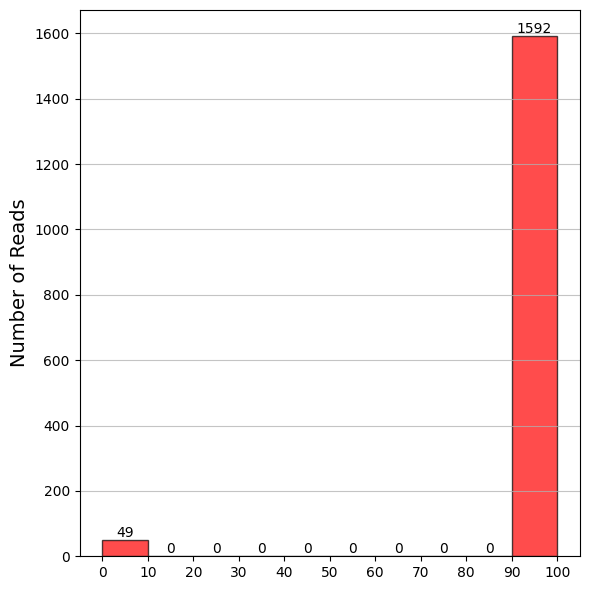

In [21]:

# Step 2: Define the bins for the histogram (0-10%, 10-20%, ..., 90-100%)
bins = range(0, 110, 10)  # This creates bins: [0-10), [10-20), ..., [90-100]

# Step 3: Plot the histogram
plt.figure(figsize=(6, 6))
n, bins, patches = plt.hist(
    df_mC['Proportion_sub_CDR(%)'],
    bins=bins,
    edgecolor='black',
    alpha=0.7,
    color='red'
)

# Step 4: Customize the plot
#plt.xlabel('Proportion of sub CDR where mCpG < top 10% percentile of chromosome methylation', fontsize=14)
plt.ylabel('Number of Reads', fontsize=14)
#plt.title('Histogram of single read sub CDR methylation < top 10% percentile of chromosome methylation', fontsize=16)
plt.xticks(bins)  # Set x-axis ticks to align with bins
plt.grid(axis='y', alpha=0.75)

# Optional: Add percentage labels above each bar
for count, bin_edge in zip(n, bins):
    plt.text(
        bin_edge + 5,       # Position text in the middle of the bin
        count,               # Y-coordinate (height of the bar)
        f'{int(count)}',     # Text to display
        ha='center',
        va='bottom',
        fontsize=10
    )

# Step 5: Display the plot

plt.tight_layout()

plt.show()


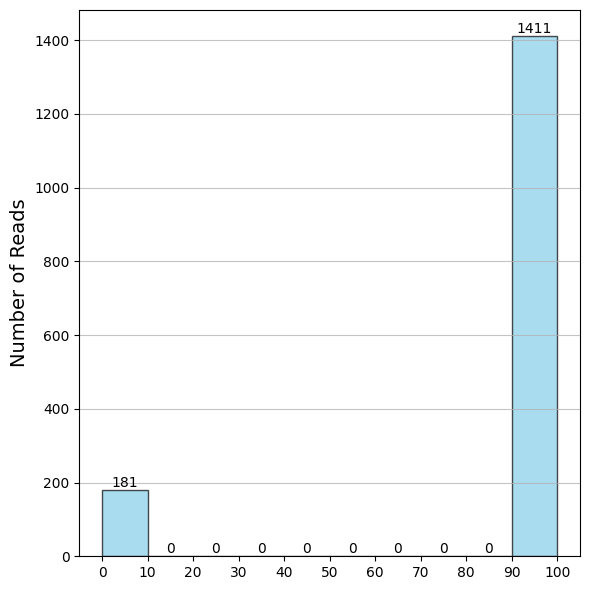

In [24]:




# Step 2: Define the bins for the histogram (0-10%, 10-20%, ..., 90-100%)
bins = range(0, 110, 10)  # This creates bins: [0-10), [10-20), ..., [90-100]

# Step 3: Plot the histogram
plt.figure(figsize=(6, 6))
n, bins, patches = plt.hist(
    CENPA_filtered_df_mA['Proportion_sub_CDR(%)'],
    bins=bins,
    edgecolor='black',
    alpha=0.7,
    color='skyblue'
)

# Step 4: Customize the plot
#plt.xlabel('Proportion of CENPA Enrichment Domains per CDR (%)', fontsize=14)
plt.ylabel('Number of Reads', fontsize=14)
#plt.title('Histogram of CENPA Enrichment Proportions per CDR', fontsize=16)
plt.xticks(bins)  # Set x-axis ticks to align with bins
plt.grid(axis='y', alpha=0.75)

# Optional: Add percentage labels above each bar
for count, bin_edge in zip(n, bins):
    plt.text(
        bin_edge + 5,       # Position text in the middle of the bin
        count,               # Y-coordinate (height of the bar)
        f'{int(count)}',     # Text to display
        ha='center',
        va='bottom',
        fontsize=10
    )

# Step 5: Display the plot

plt.tight_layout()

plt.show()


In [29]:


# Filter reads with Proportion_sub_CDR(%) < 100
reads_below_100_percent_CENPA = CENPA_filtered_df_mA[CENPA_filtered_df_mA['Proportion_sub_CDR(%)'] < 100]

# Count the number of reads per chromosome
chromosome_counts = reads_below_100_percent_CENPA['chromosome'].value_counts()

# Print the chromosome counts
print("Number of reads per chromosome:")
print(chromosome_counts)

# Retrieve the corresponding entries from both the dictionary and the DataFrame
for _, row in reads_below_100_percent_CENPA.iterrows():
    read_name = row['read names']
    chromosome = row['chromosome']
    
    # Only process reads from chr1_PATERNAL
    if chromosome == "chr1_PATERNAL":
        content_in_dataframe = row.to_dict()  # Convert the row to a dictionary for easy printing
        
        # Get the content from CENPA_spanning_reads if the read name exists
        content_in_dictionary = CENPA_spanning_reads.get(read_name, "Not Found in CENPA_spanning_reads")

        # Print the read name, chromosome, its content from the DataFrame, and its content from the dictionary
        print(f"Read Name: {read_name} (Chromosome: {chromosome})")
        print(f"Content in DataFrame: {content_in_dataframe}")
        print(f"Content in CENPA_spanning_reads: {content_in_dictionary}")
        print("-" * 80)



Number of reads per chromosome:
chromosome
chrX_MATERNAL     29
chr13_MATERNAL    22
chr20_MATERNAL    21
chr4_MATERNAL     20
chr16_MATERNAL    15
chr4_PATERNAL     14
chr10_PATERNAL    13
chr17_PATERNAL    11
chr6_PATERNAL     11
chr3_PATERNAL     10
chr12_MATERNAL    10
chr7_PATERNAL     10
chr5_MATERNAL      9
chr3_MATERNAL      9
chr2_MATERNAL      8
chr17_MATERNAL     7
chr9_MATERNAL      7
chr9_PATERNAL      7
chr21_PATERNAL     7
chr10_MATERNAL     7
chr11_PATERNAL     6
chr19_PATERNAL     6
chr16_PATERNAL     6
chr1_PATERNAL      6
chr15_PATERNAL     5
chr1_MATERNAL      5
chr5_PATERNAL      5
chr6_MATERNAL      5
chr12_PATERNAL     4
chr11_MATERNAL     4
chr19_MATERNAL     4
chr15_MATERNAL     4
chr18_PATERNAL     3
chr7_MATERNAL      3
chr14_MATERNAL     2
chr8_MATERNAL      2
chr20_PATERNAL     2
chr18_MATERNAL     1
chr2_PATERNAL      1
chr22_MATERNAL     1
chr21_MATERNAL     1
Name: count, dtype: int64
Read Name: 0872594e-6eac-45ee-93e4-6266bd283728 (Chromosome: chr1_PATE